# Feedforward Neural Network on the MNIST dataset

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST

## MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

### Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

### MNIST
Loading the MNIST dataset and ploting a few examples:

In [31]:
mnist_trainset = MNIST("./temp/", train=True, download=True)
mnist_testset = MNIST("./temp/", train=False, download=True)

In [32]:
# To speed up training we'll only work on a subset of the data
x_train = mnist_trainset.data[:1000].view(-1, 784).float()
targets_train = mnist_trainset.targets[:1000]

x_valid = mnist_trainset.data[1000:1500].view(-1, 784).float()
targets_valid = mnist_trainset.targets[1000:1500]

x_test = mnist_testset.data[:500].view(-1, 784).float()
targets_test = mnist_testset.targets[:500]

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

print(targets_train[:10])

Information on dataset
x_train torch.Size([1000, 784])
targets_train torch.Size([1000])
x_valid torch.Size([500, 784])
targets_valid torch.Size([500])
x_test torch.Size([500, 784])
targets_test torch.Size([500])
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])


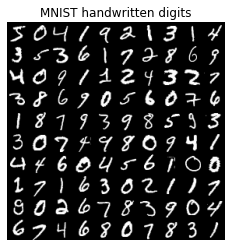

In [33]:
# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Implementing the network

Creating a FNN using Kaiming He initialization. To add some regularization, we added some dropout and batch normalisation. We also used weight regularization (i.e. weight decay).

In [34]:
#Hyperparameters
num_classes = 10
num_l1 = 512
num_l2 = 512
num_l3 = 128
num_features = x_train.shape[1]
dropoutPercentage = 0.4

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_hidden3, num_output, dropoutPercentage):
        super(Net, self).__init__()  
        # input layer
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1, num_features)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        self.bn_1=nn.BatchNorm1d(num_hidden1)
        # hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden2, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_hidden2), 0))
        self.bn_2=nn.BatchNorm1d(num_hidden2)
        # hidden layer 2
        self.W_3 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden3, num_hidden2)))
        self.b_3 = Parameter(init.constant_(torch.Tensor(num_hidden3), 0))
        self.bn_3=nn.BatchNorm1d(num_hidden3)
        # hidden layer 3
        self.W_4 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden3)))
        self.b_4 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        # define activation function
        self.activation1 = torch.nn.ELU()
        self.activation2 = torch.nn.ELU()
        self.activation3 = torch.nn.ReLU()

        self.dropout = nn.Dropout(dropoutPercentage)

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation1(self.bn_1(x)) #BatchNorm
        x = F.linear(x, self.W_2, self.b_2)
        x = self.dropout(self.activation2(self.bn_2(x))) #Dropout + BatchNorm
        x = F.linear(x, self.W_3, self.b_3)
        x = self.dropout(self.activation3(self.bn_3(x))) #Dropout + BatchNorm
        x = F.linear(x, self.W_4, self.b_4)

        return x


net = Net(num_features, num_l1, num_l2, num_l3, num_classes, dropoutPercentage)

In [35]:
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-5) #weight_decay adds regularization
criterion = nn.CrossEntropyLoss()

In [36]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(torch.from_numpy(x)).size())

torch.Size([45, 10])


# Build the training loop

Implementing the training loop using mini batches.

Epoch  1 : Train Loss 0.318270 , Train acc 0.083000, Valid acc 0.090000
Epoch 11 : Train Loss 0.255351 , Train acc 0.298000, Valid acc 0.242000
Epoch 21 : Train Loss 0.197575 , Train acc 0.509000, Valid acc 0.424000
Epoch 31 : Train Loss 0.166090 , Train acc 0.676000, Valid acc 0.534000
Epoch 41 : Train Loss 0.138061 , Train acc 0.739000, Valid acc 0.620000
Epoch 51 : Train Loss 0.120635 , Train acc 0.785000, Valid acc 0.674000
Epoch 61 : Train Loss 0.109956 , Train acc 0.815000, Valid acc 0.718000
Epoch 71 : Train Loss 0.100579 , Train acc 0.835000, Valid acc 0.736000
Epoch 81 : Train Loss 0.089813 , Train acc 0.848000, Valid acc 0.756000
Epoch 91 : Train Loss 0.086098 , Train acc 0.864000, Valid acc 0.780000
Epoch 101 : Train Loss 0.074232 , Train acc 0.882000, Valid acc 0.788000
Epoch 111 : Train Loss 0.073906 , Train acc 0.886000, Valid acc 0.806000
Epoch 121 : Train Loss 0.067882 , Train acc 0.897000, Valid acc 0.828000
Epoch 131 : Train Loss 0.066981 , Train acc 0.903000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

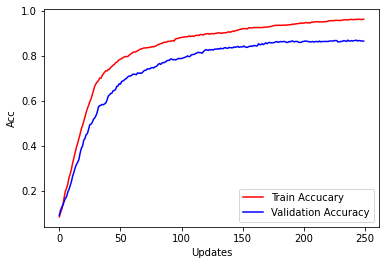

In [37]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score

# normalize the inputs (gray scale image)
x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 250
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce]) #Get the mini batch
        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

## Credits
> The code is partially based on https://github.com/DeepLearningDTU (Deep Learning course DTU).